### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pathlib import Path

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import specificity_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

### Main Script

In [6]:
def load_data(dataset):
    
    df_encoded = pd.read_csv(f'../Data & Outputs/{dataset}/df_encoded.csv') #load the processed data
    y = df_encoded['churn']
    X = df_encoded.drop(columns=['churn'])

    df_normalized = pd.read_csv(f'../Data & Outputs/{dataset}/df_normalized.csv') #load the normalized data
    y_norm = df_normalized['churn']
    X_norm = df_normalized.drop(columns=['churn'])

    return X, y, X_norm, y_norm, df_normalized


def create_model(classifier):
    if classifier == 'RF':
        model = RandomForestClassifier(n_jobs=-1, random_state=42)
    elif classifier == 'BRF':
        model = BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
    else:
        model = XGBClassifier(n_jobs=-1, random_state=42)
    return model

def visualize_corr_heatmap(df_normalized, dataset):
    # code for visualizing the correlation heatmap
    corr = df_normalized.corr()

    plt.figure(figsize=(20,10)) 
    sns.heatmap(corr, annot=True, cmap='RdBu', annot_kws={"size": 10, "color": "white"})

    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_corr_heatmap.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_corr_heatmap.pdf', bbox_inches='tight')
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_corr_heatmap.eps', bbox_inches='tight')
    plt.show()

def feature_selection_corr(X_norm, y_norm, dataset):
    k = 10
    corr = abs(X_norm.corrwith(y_norm))
    corr = corr.sort_values(ascending=False)
    
    #top k correlation features
    corr_features = corr.index[:k]
    
    sns.set_theme(style="whitegrid", font_scale=1.5)
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    corr_sorted = corr.sort_values(ascending=False)
    # Define a dictionary to map each feature to a color
    colors = {feat: '#55A868' if feat in corr_features else '#4C72B0' for feat in corr_sorted.index}
    # Create the bar plot with custom color
    sns.barplot(x=corr_sorted.values, y=corr_sorted.index, 
                hue=corr_sorted.index, palette=colors, ax=ax, legend=False)
    
    ax.set_xlabel('Correlation with target variable')
    ax.set_ylabel('Features')
    ax.set_title('Correlation between Features and Target Variable', fontsize=20)

    # Set the x axis tick labels to display as percentage
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

    # Add a legend to indicate selected and unselected features
    selected_patch = mpatches.Patch(color='#55A868', label='Selected features')
    unselected_patch = mpatches.Patch(color='#4C72B0', label='Other features')
    ax.legend(handles=[selected_patch, unselected_patch], fontsize=12)

    # Adjust the spacing between the bars and the edges of the plot
    sns.despine(trim=True)

    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_correlation.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_correlation.pdf', bbox_inches='tight')
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_correlation.eps', bbox_inches='tight')

    # Display the plot
    plt.show()

    return list(corr_features)

def feature_selection_chi_sq(X_norm, y_norm, dataset):
    k = 10
    selector = SelectKBest(score_func=chi2, k=k)
    selector.fit(X_norm, y_norm)
    scores = -np.log10(selector.pvalues_)
    sorted_indices = scores.argsort()[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_feature_names = X_norm.columns[sorted_indices]

    chi_sq_features = sorted_feature_names[:k]
    
   
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    # set default color for all bars
    sns_color = '#4C72B0'
    # change color for selected features
    bar_colors = [sns_color if f not in chi_sq_features else '#55A868' for f in sorted_feature_names]

    sns.barplot(x=sorted_scores, y=sorted_feature_names, 
                hue=sorted_feature_names, palette=bar_colors, legend=False)

    ax.set_xlabel(r'Chi-squared scores', fontsize=14)
    ax.set_ylabel(r'Features', fontsize=14)

    # Format y-axis tick labels
    ax.tick_params(axis='y', labelsize=12)

    # Add legend for selected features
    selected_patch = mpatches.Patch(color='#55A868', label='Selected features')
    sns_patch = mpatches.Patch(color=sns_color, label='Other features')
    plt.legend(handles=[selected_patch, sns_patch], prop={'size': 12})

    # Set title
    ax.set_title(r'Chi-squared scores of features', fontsize=16)

    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_chi2.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_chi2.pdf', bbox_inches='tight')
    # plt.savefig(f'../Data & Outputs/{dataset}/{dataset}_chi2.eps', bbox_inches='tight')
    plt.show()

    return list(chi_sq_features)

def feature_selection_sfs(X, y, dataset, classifier, model):

    pipeline_sfs = Pipeline([
    ('scaler', MinMaxScaler().set_output(transform="pandas")),
    ('model', model)
    ])
    
    gmean_scorer = make_scorer(geometric_mean_score)
    #spec_scorer = make_scorer(specificity_score)


    sfs = SFS(pipeline_sfs, k_features='best', forward=False, floating=False, 
              scoring=gmean_scorer, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
    
    #USE THE FOLLOWING FOR BETTER SCORE (CONSUMES MORE TIME)
    
    # sfs = SFS(pipeline_sfs, 
    #     k_features='best', 
    #     forward=False, 
    #     floating=True, 
    #     scoring=gmean_scorer, 
    #     cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42), 
    #     n_jobs=-1)
    
    sfs = sfs.fit(X, y)
    seq_fea_sel_features = list(sfs.k_feature_names_)

    plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(10, 6))

    plt.title('Sequential Feature Selection (w. StdDev)')
    plt.xlabel('Number of Features')
    plt.ylabel('Geometric Mean Score')
    plt.grid(True)

    # Format axis labels and ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().tick_params(axis='both', which='both', length=0)

    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_seq_fea_sel.pdf', bbox_inches='tight')
    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_seq_fea_sel.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_seq_fea_sel.eps', bbox_inches='tight')

    plt.show()

    return seq_fea_sel_features
    
def feature_selection_rfecv(X, y, dataset, classifier, model):
    class MyPipeline(Pipeline):
        @property
        def coef_(self):
            return self._final_estimator.coef_
        @property
        def feature_importances_(self):
            return self._final_estimator.feature_importances_

    scaler = MinMaxScaler().set_output(transform="pandas")
    pipeline_rfecv = MyPipeline(steps=[("scale",scaler),("model", model)])

    gmean_scorer = make_scorer(geometric_mean_score)
    #spec_scorer = make_scorer(specificity_score)

    
    rfecv = RFECV(pipeline_rfecv, cv=StratifiedKFold(n_splits=5), scoring=gmean_scorer, n_jobs=-1)
    
    #USE THE FOLLOWING FOR BETTER SCORE (CONSUMES MORE TIME)
    # rfecv = RFECV(pipeline_rfecv, 
    #     cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42), 
    #     scoring=gmean_scorer, n_jobs=-1)

    rfecv = rfecv.fit(X, y)
    rfe_cv_features = X.columns[rfecv.support_] #column names of the best features

    # Plot the number of features VS. cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.title('Recursive Feature Elimination (w. StdDev)')
    plt.xlabel('Number of features selected')
    plt.ylabel('Geometric Mean Score')
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             label='CV score', marker='o', color='blue')

    # Plot the standard deviation as a shaded region
    plt.fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
                    rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                    rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'], 
                    alpha=0.2, label='StdDev', color='cornflowerblue')

    # Set x-axis tick labels as integers
    plt.xticks(list(range(1, len(rfecv.cv_results_['mean_test_score']) + 1)))

    plt.legend(loc='lower right')
    plt.grid(True)
    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_rfecv.pdf', bbox_inches='tight')
    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_rfecv.png', bbox_inches='tight', dpi=300)
    # plt.savefig(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_rfecv.eps', bbox_inches='tight')
    plt.show()
    
    return rfe_cv_features

def save_uni_selected_features(dataset, corr_features, chi_sq_features): 
    with open(f'../Data & Outputs/{dataset}/{dataset}_uni_selected_features.pkl', 'wb') as f: 
        pickle.dump([corr_features, chi_sq_features], f)

def save_mul_selected_features(dataset, classifier, seq_fea_sel_features, rfe_cv_features):
    with open(f'../Data & Outputs/{dataset}/{classifier}/{dataset}_{classifier}_mul_selected_features.pkl', 'wb') as f: 
        pickle.dump([seq_fea_sel_features, rfe_cv_features], f)


def main():
    for dataset in ['Orange', 'IBM']:
        print("Dataset: ", dataset)

        X, y, X_norm, y_norm, df_normalized = load_data(dataset)
        visualize_corr_heatmap(df_normalized, dataset)
        
        corr_features = feature_selection_corr(X_norm, y_norm, dataset)
        chi_sq_features = feature_selection_chi_sq(X_norm, y_norm, dataset)
    
        save_uni_selected_features(dataset, 
                                   corr_features, 
                                   chi_sq_features)

        for classifier in ['XGB', 'RF', 'BRF']:
            print("Classifier: ", classifier)

            model = create_model(classifier)

            rfe_cv_features = feature_selection_rfecv(X, y, dataset, classifier, model)
            seq_fea_sel_features = feature_selection_sfs(X, y, dataset, classifier, model)
            
            save_mul_selected_features(dataset, 
                                       classifier,
                                       seq_fea_sel_features, 
                                       rfe_cv_features)

### Run Script

Dataset:  Orange


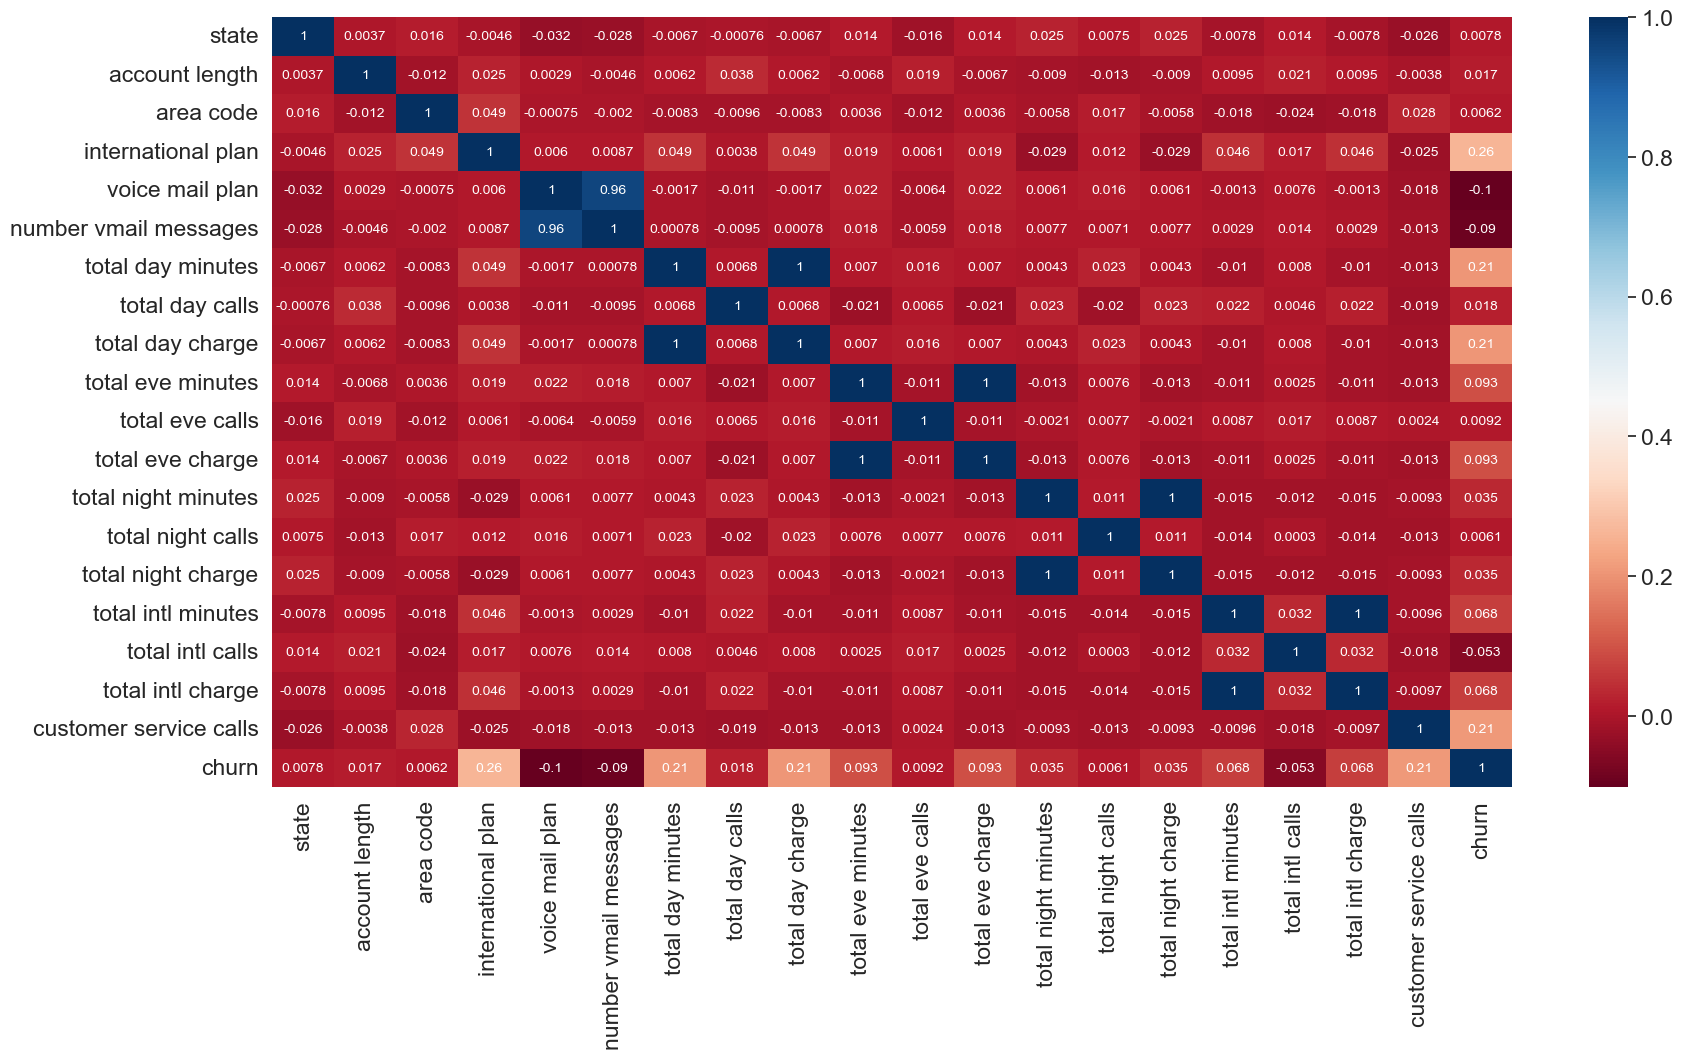

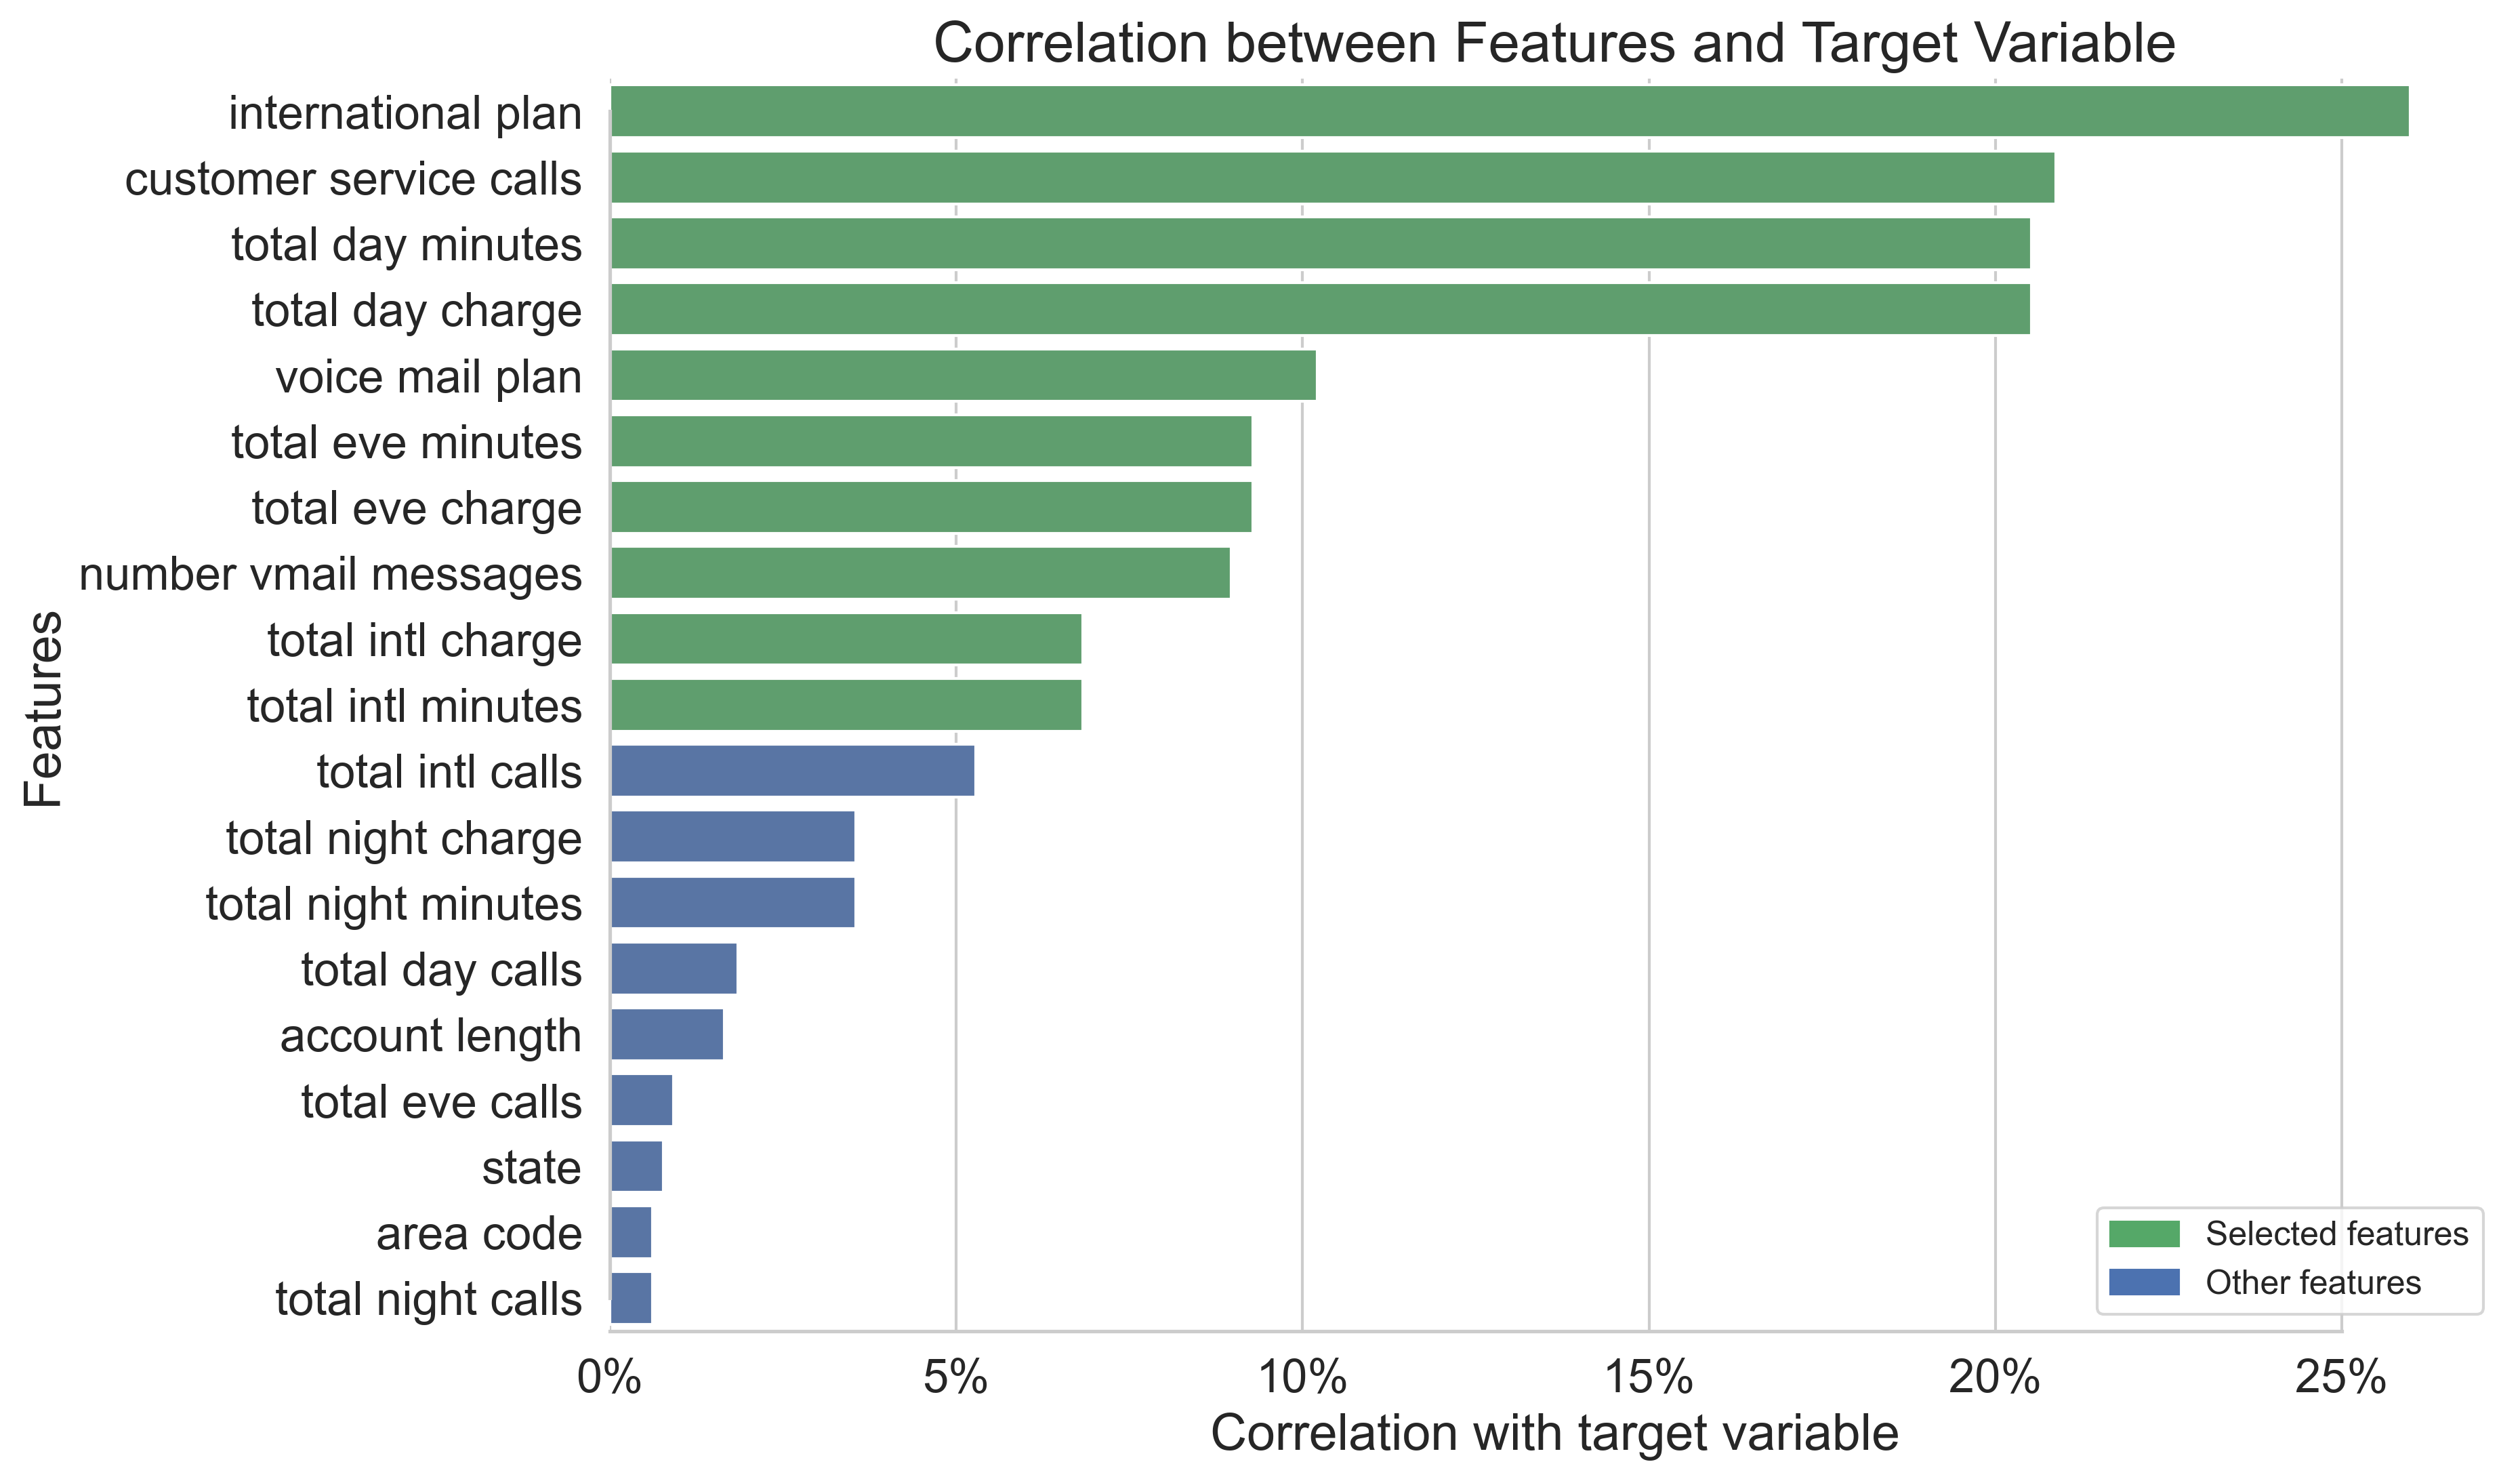

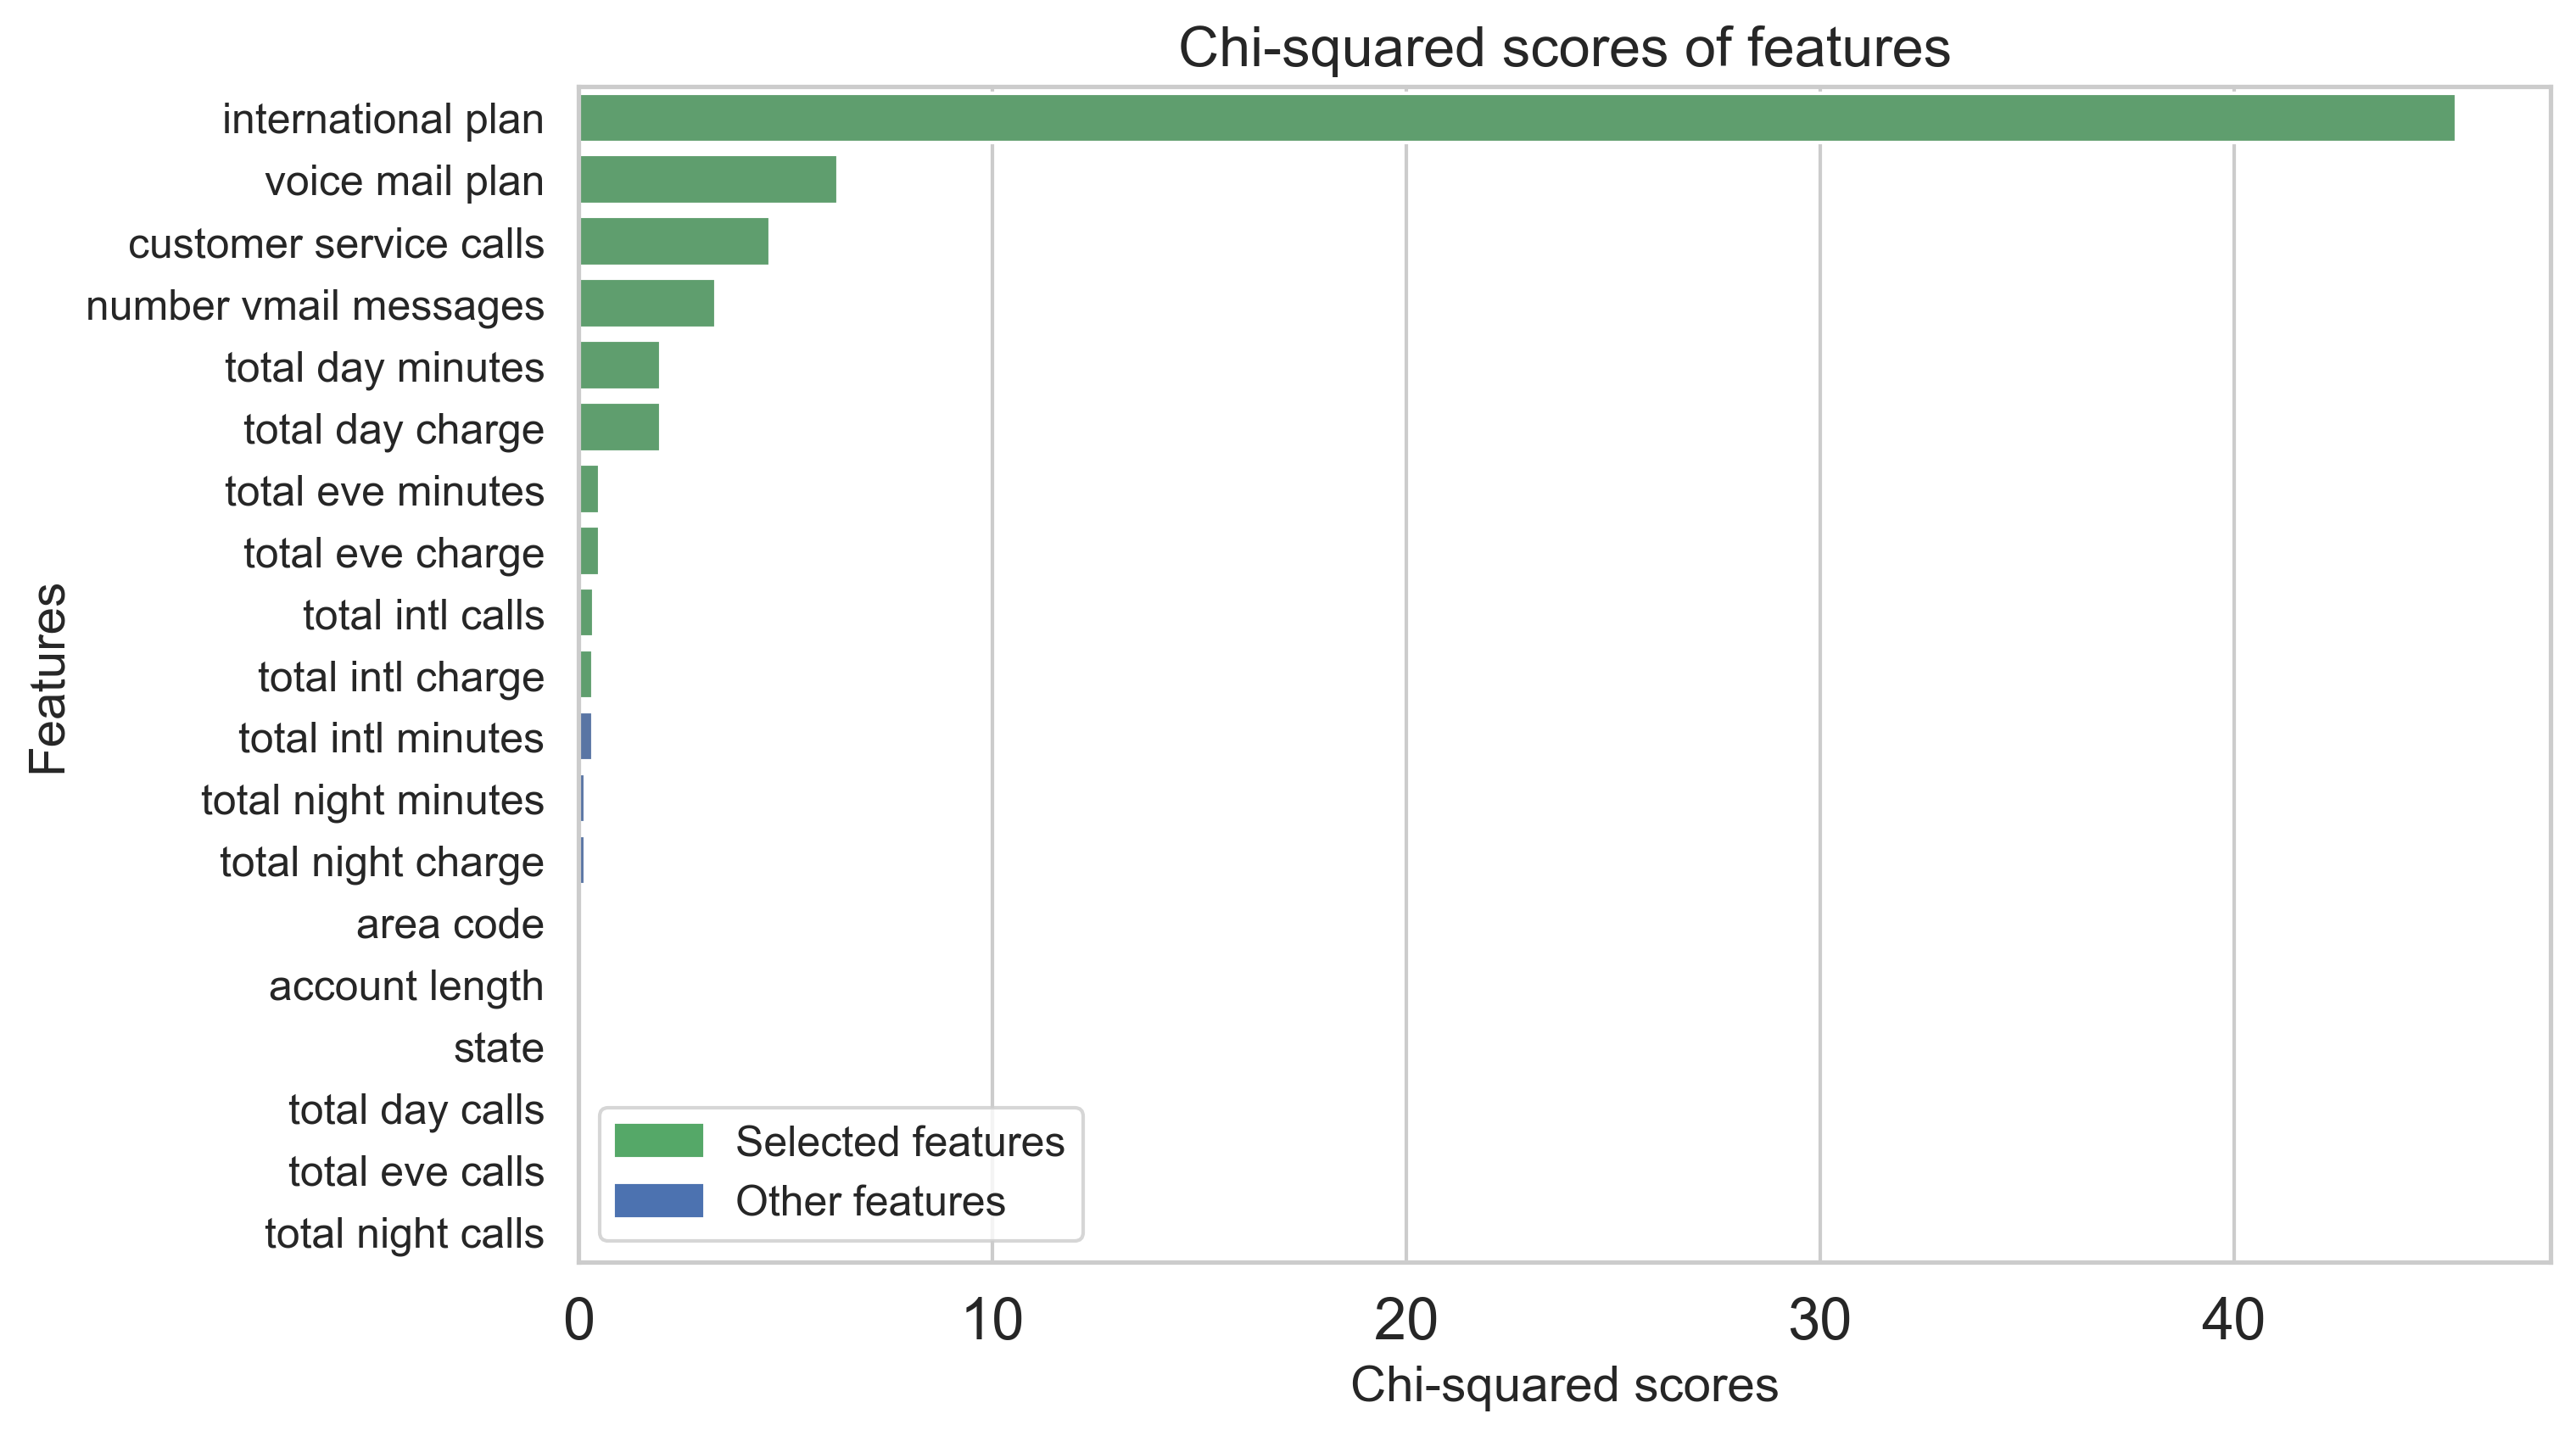

Classifier:  XGB


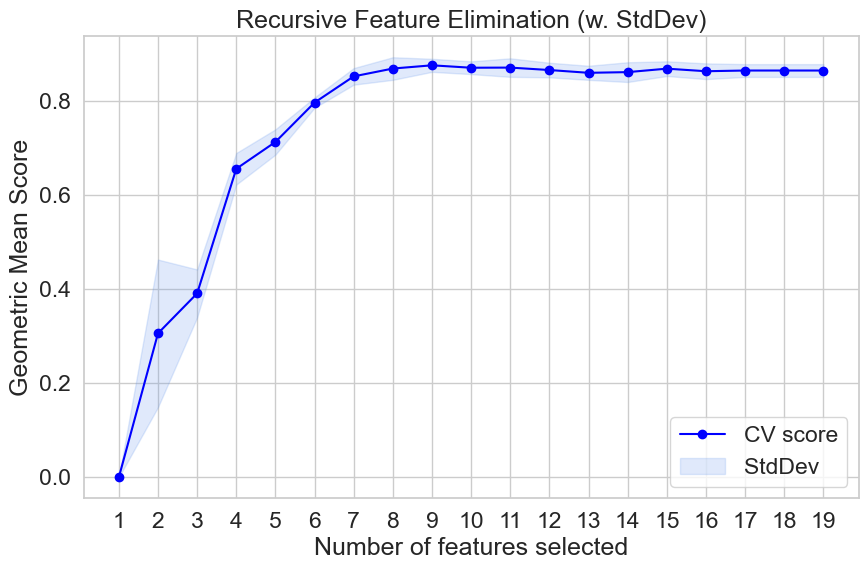

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


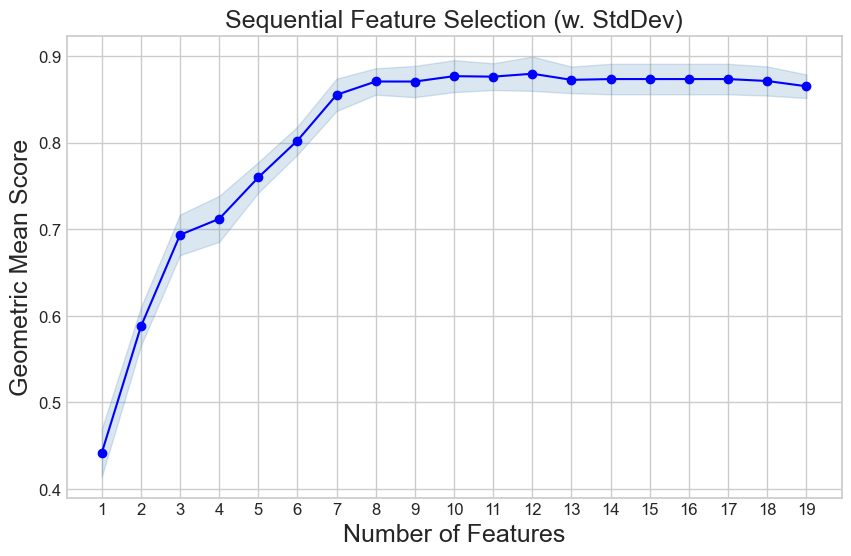

Classifier:  RF


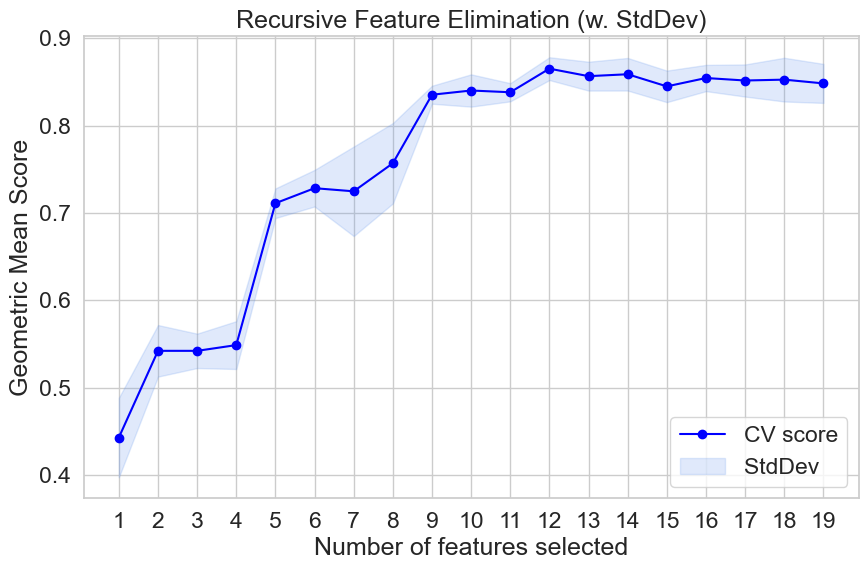

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


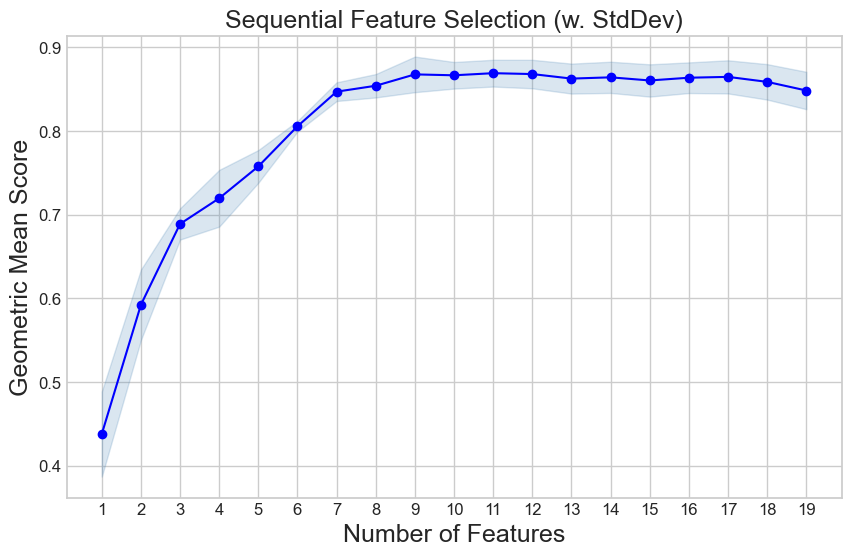

Classifier:  BRF


e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
e:

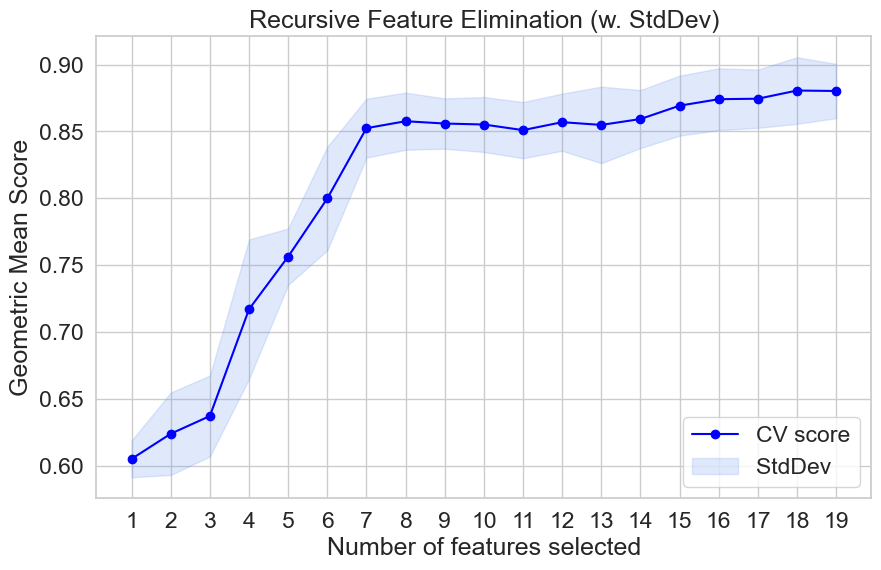

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:600: FutureWarning: The default 

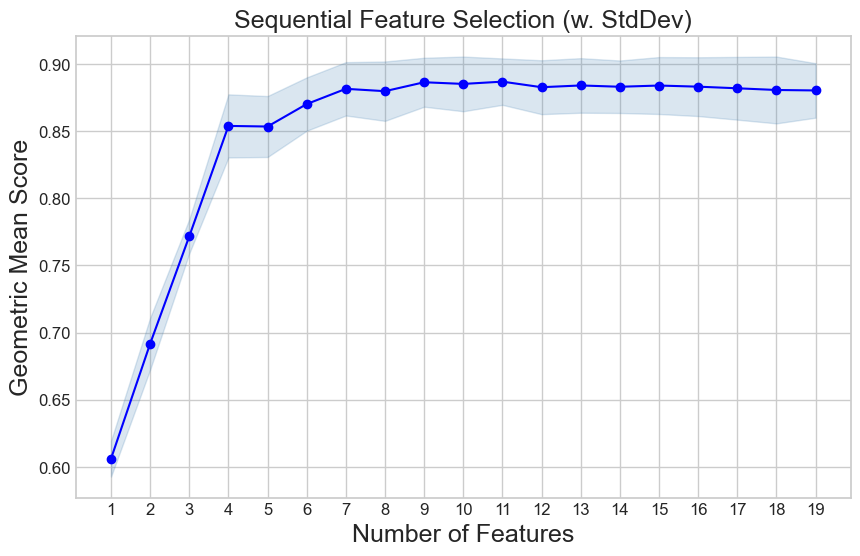

Dataset:  IBM


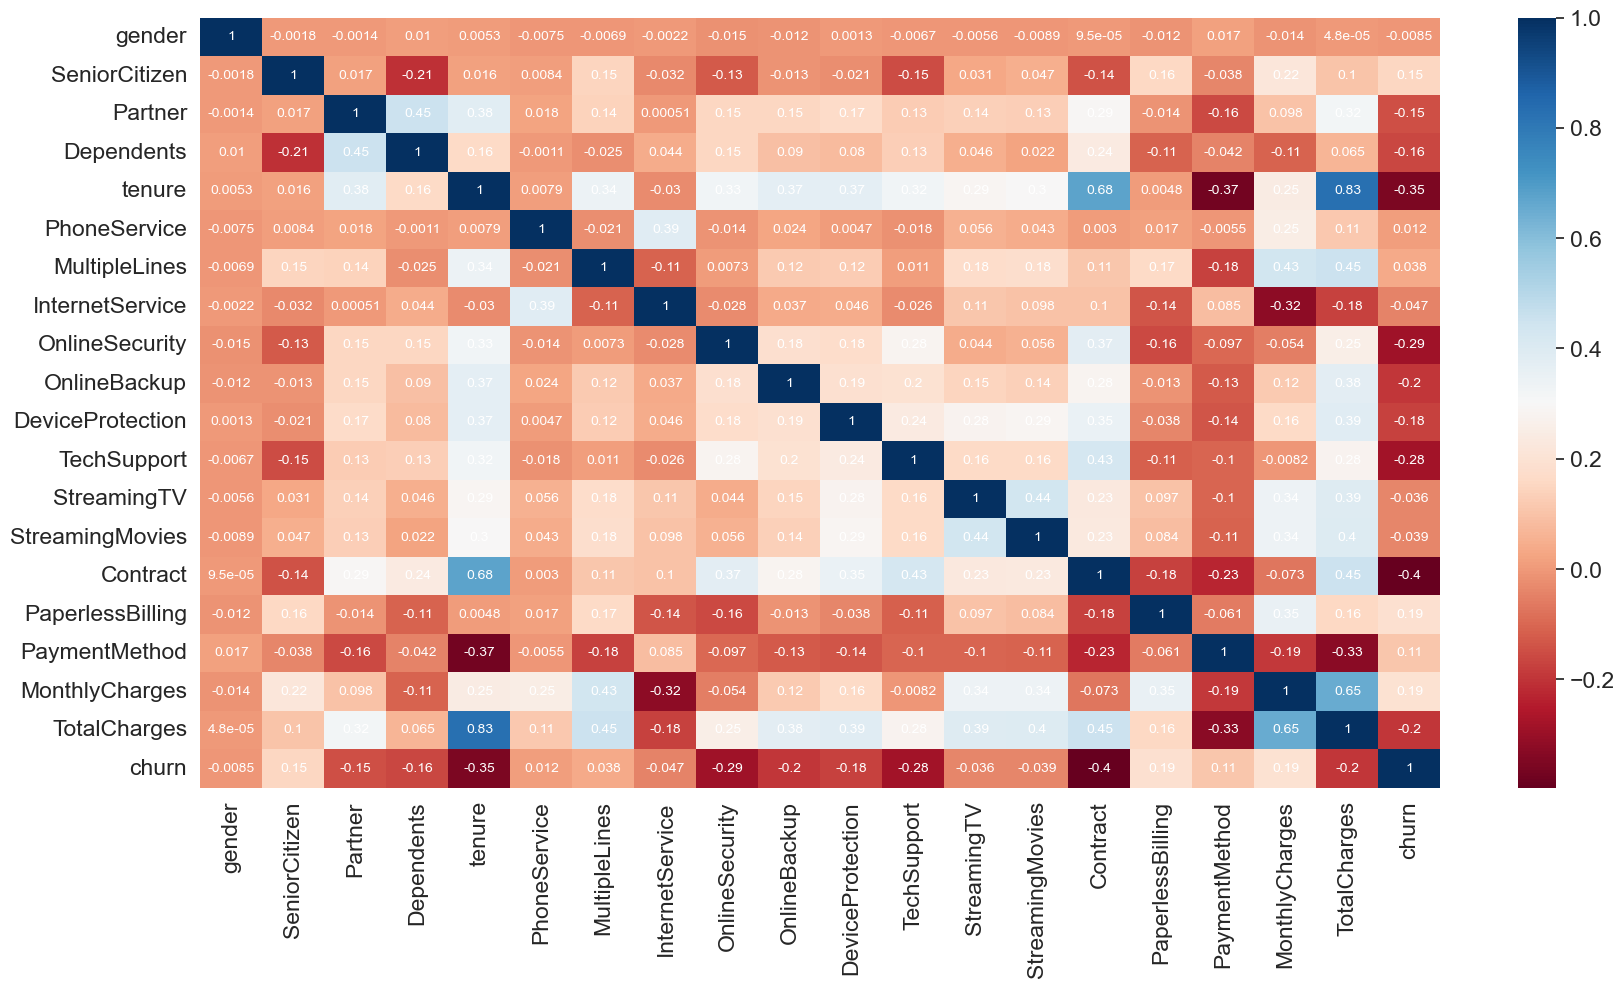

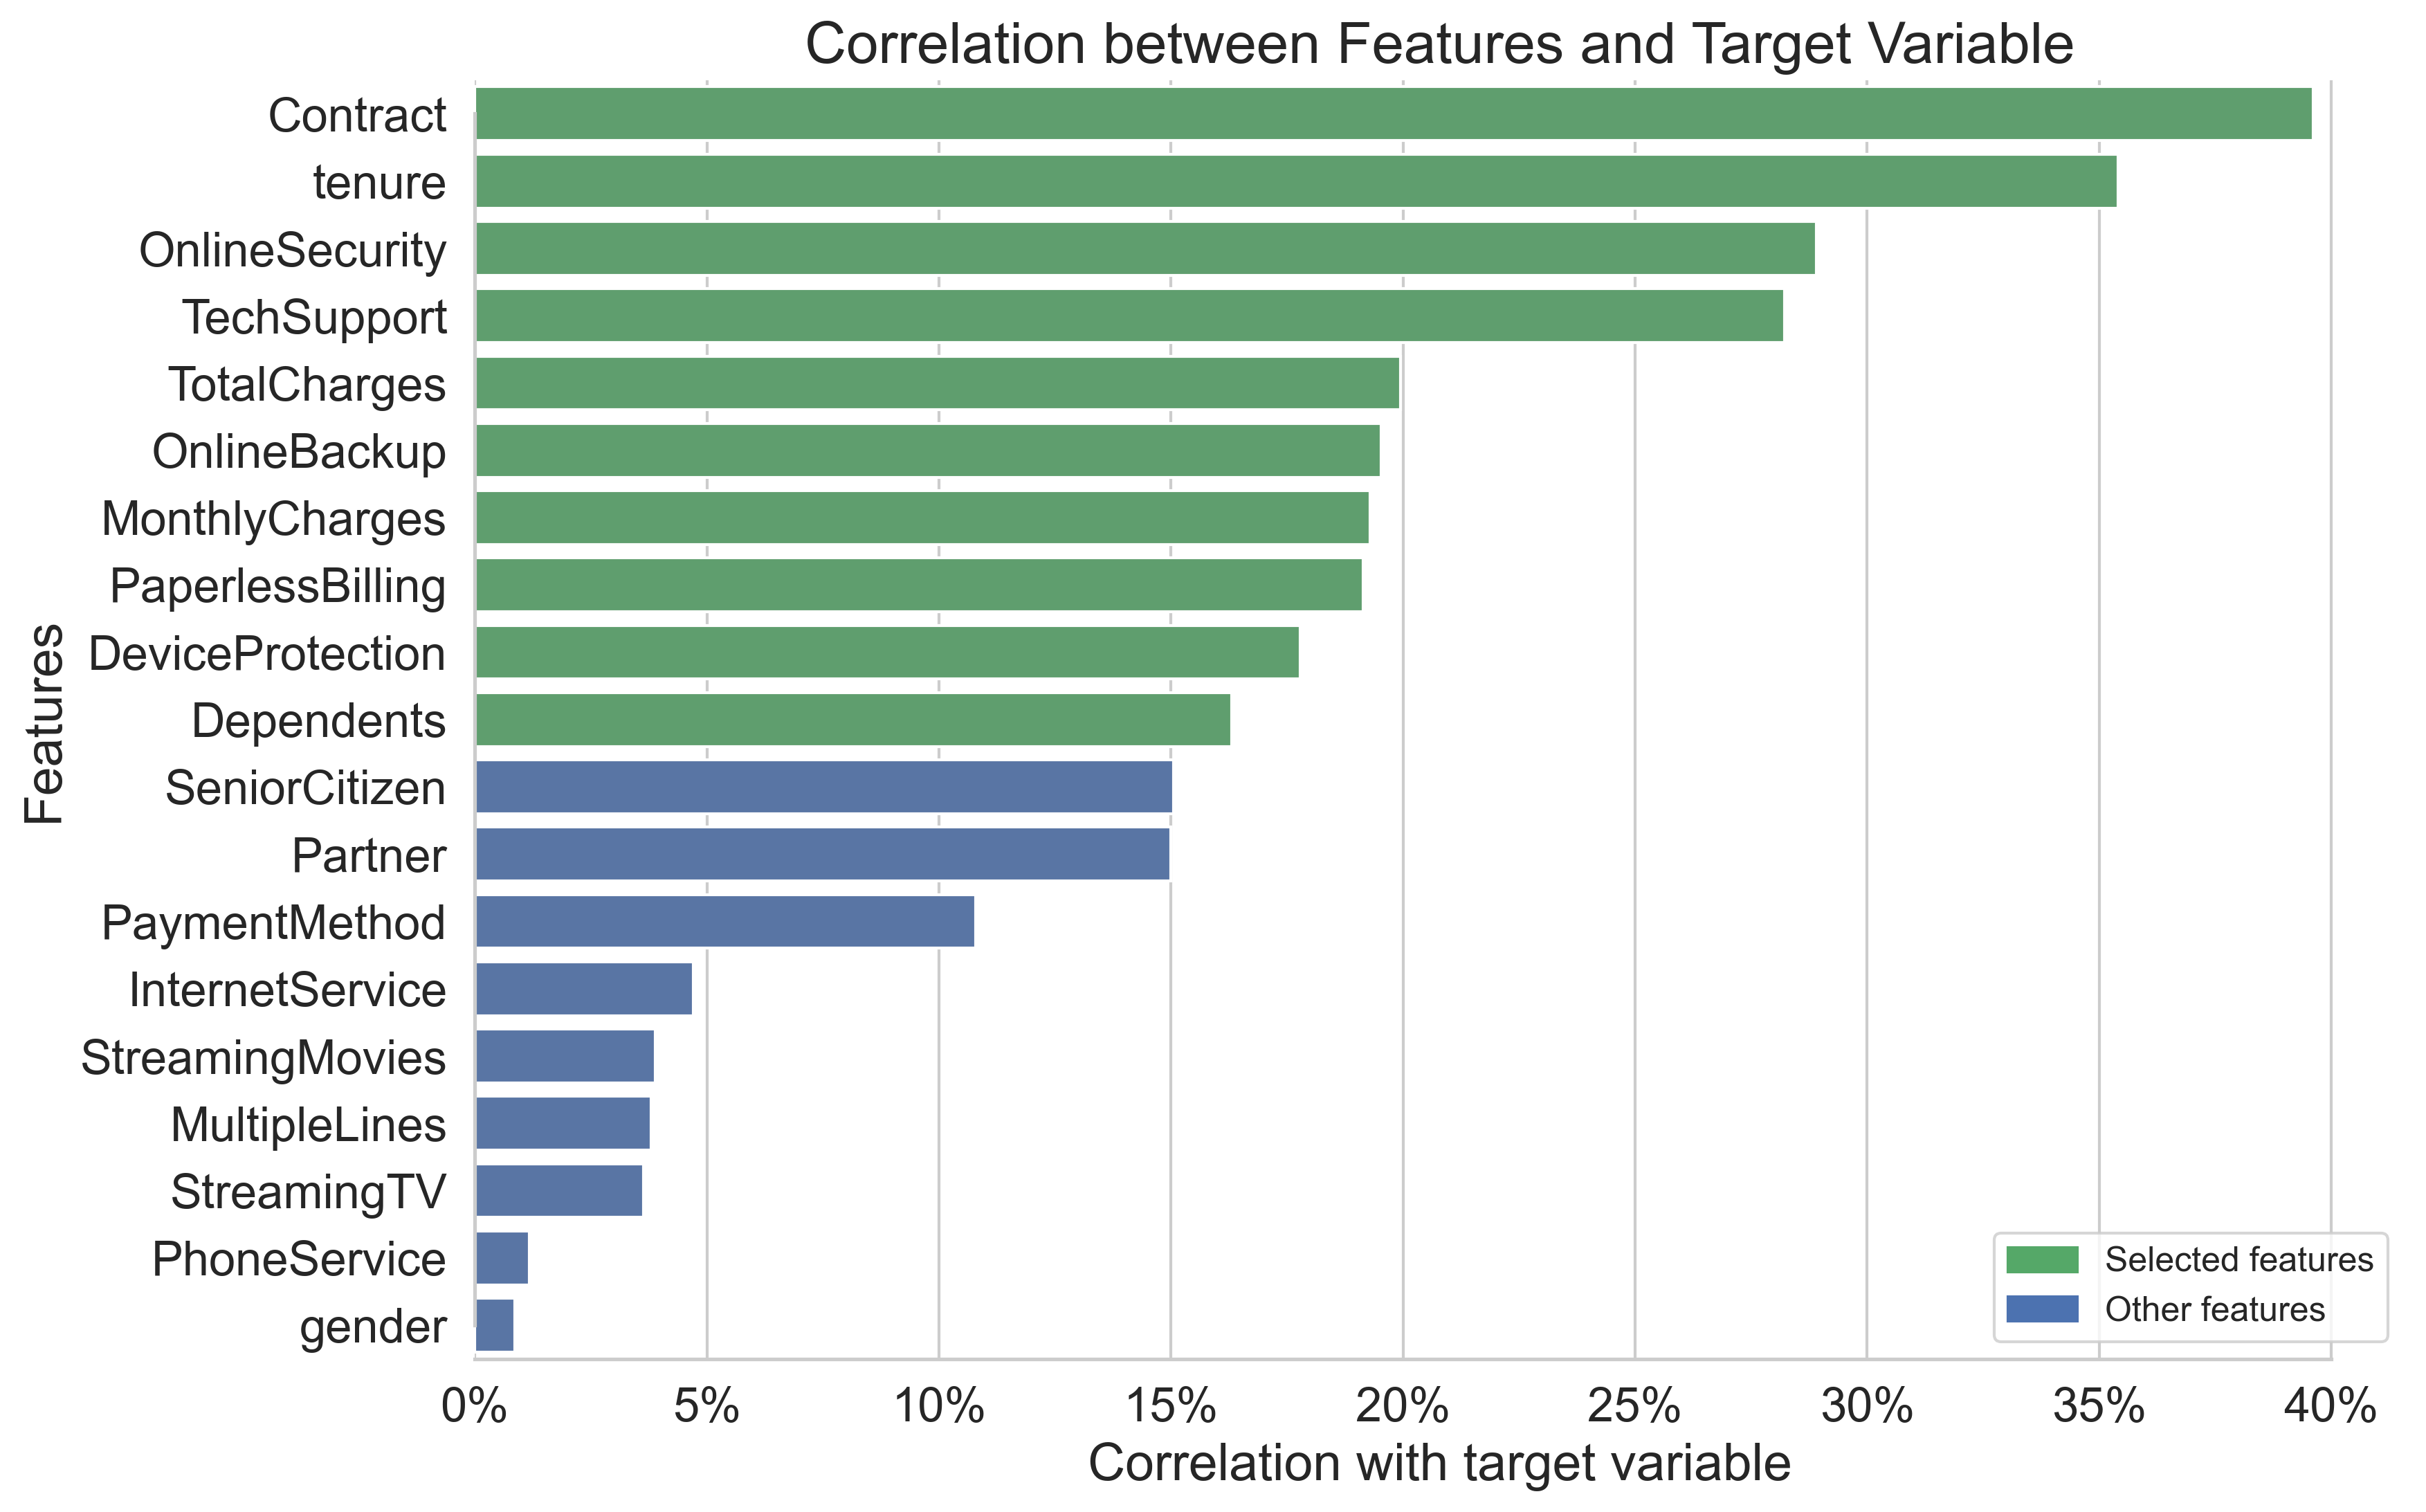

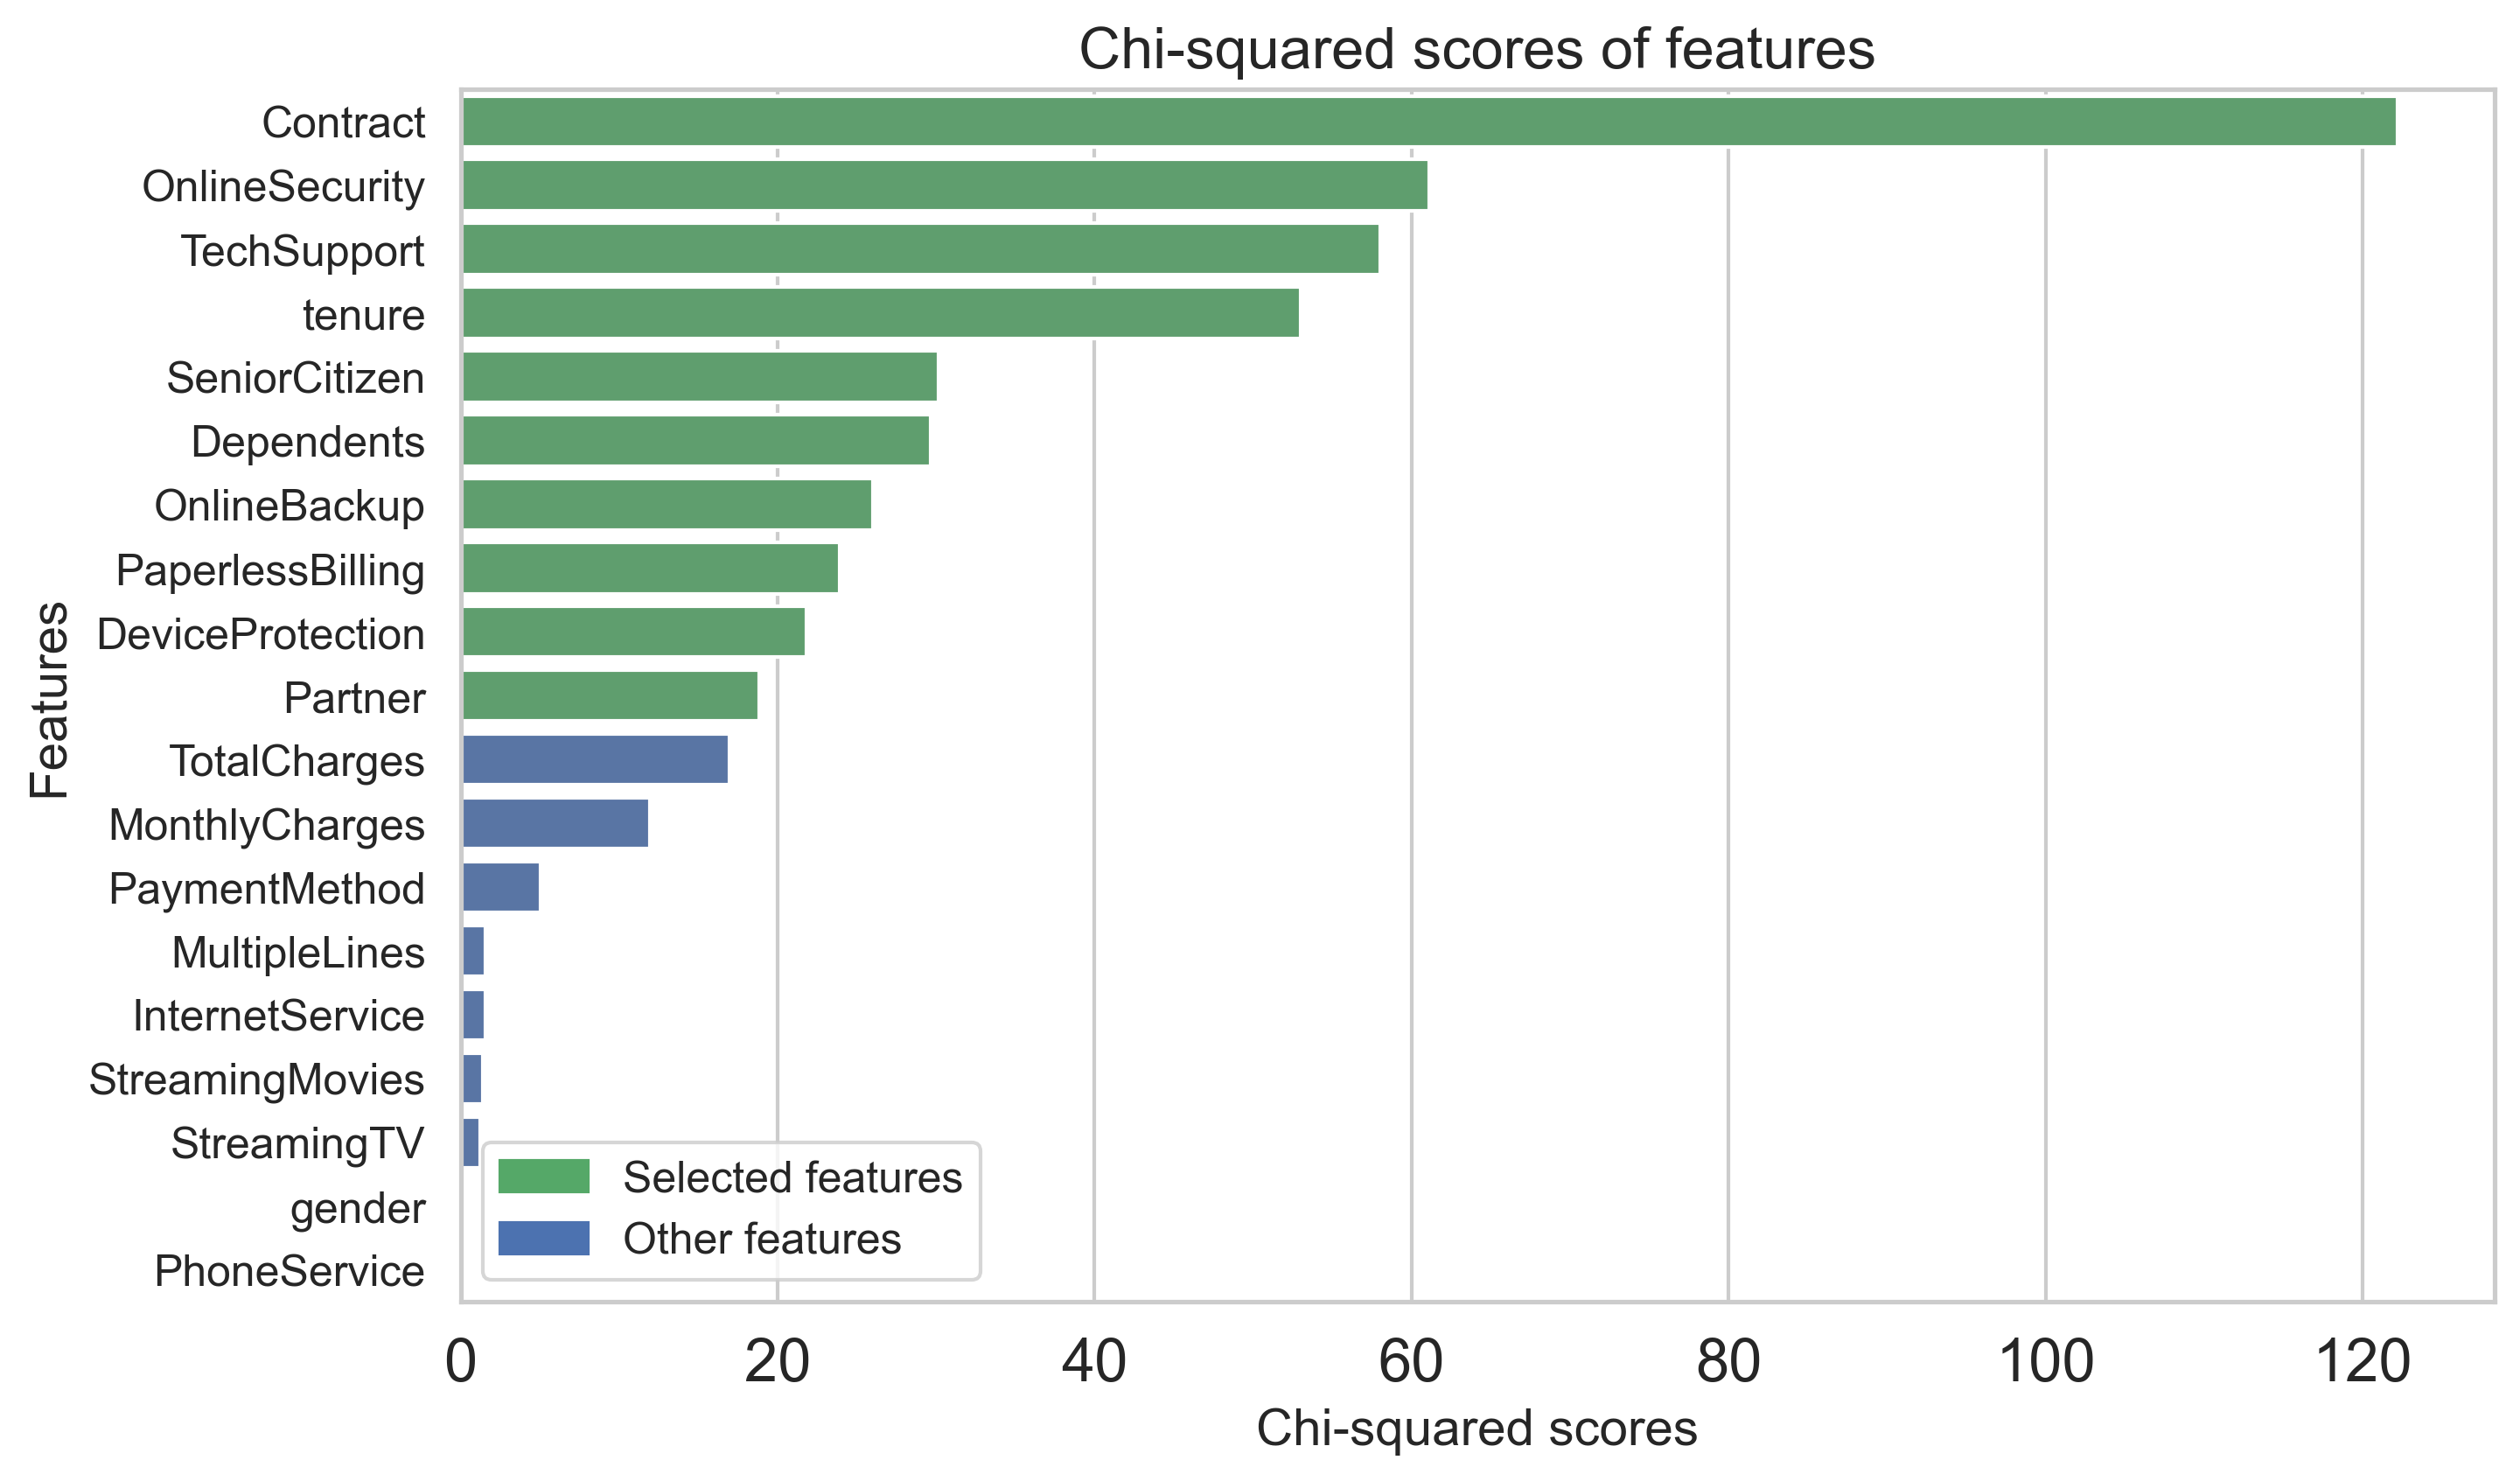

Classifier:  XGB


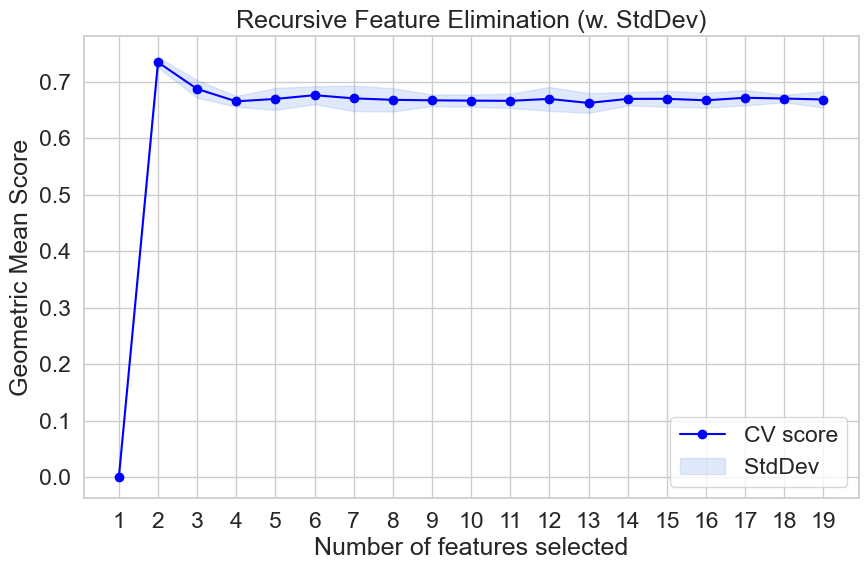

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


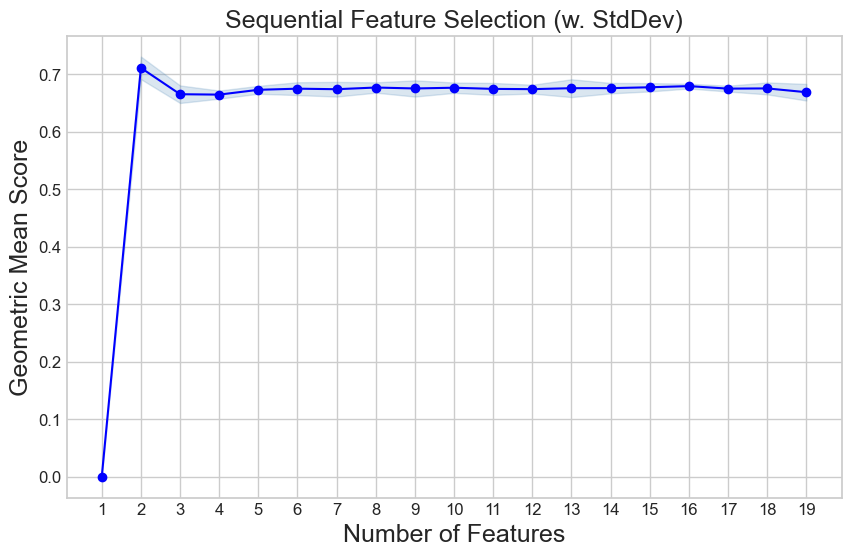

Classifier:  RF


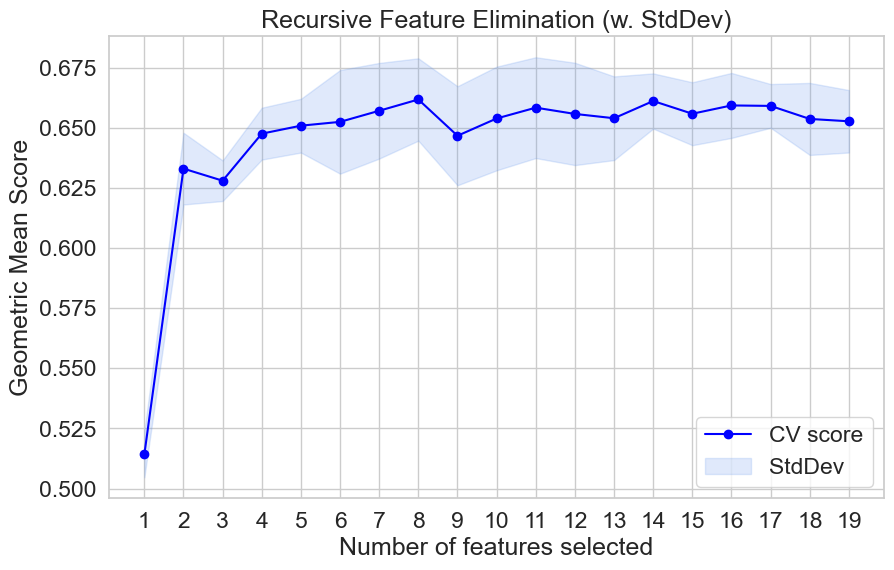

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


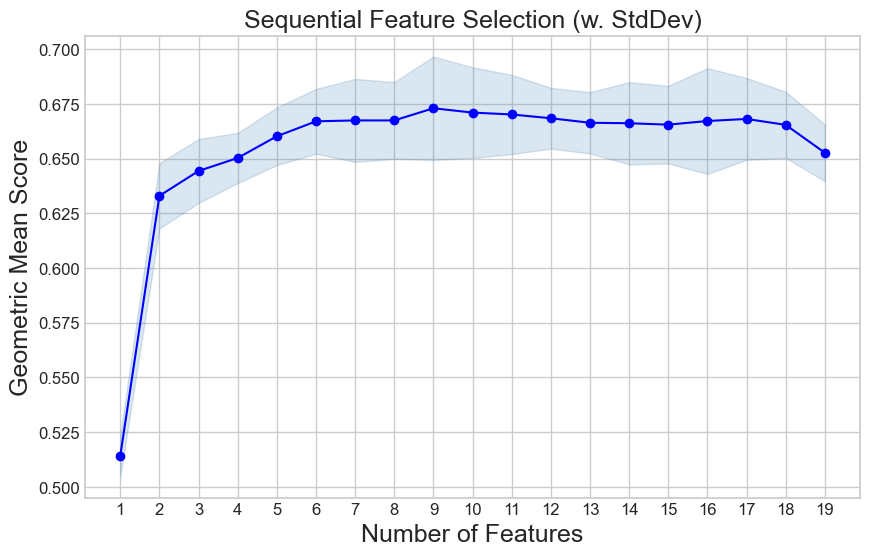

Classifier:  BRF


e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
e:

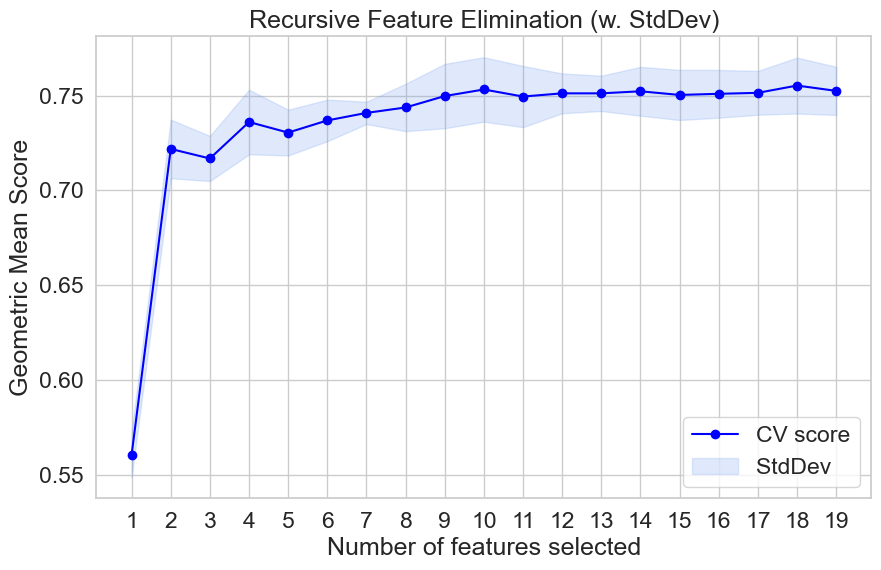

e:\Anaconda\envs\ml_new_vers\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
e:\Anaconda\envs\ml_new_vers\Lib\site-packages\imblearn\ensemble\_forest.py:600: FutureWarning: The default 

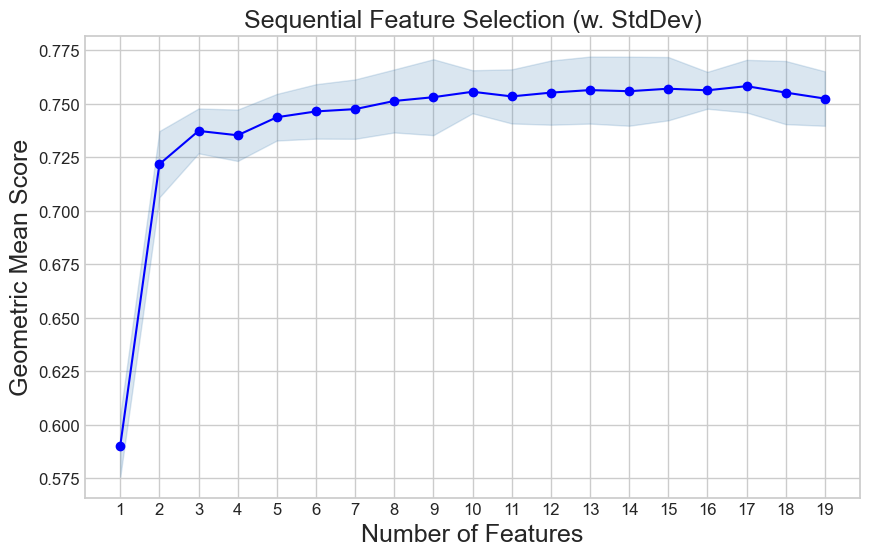

In [7]:
if __name__ == "__main__":
    main()